# Wind farm optimisation - 2 GW of dedicated offshore wind for hydrogen production

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import mapclassify as mc
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib import patheffects
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point

from h2ss import capacity as cap
from h2ss import data as rd
from h2ss import functions as fns
from h2ss import optimisation as opt

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

## Constraints

In [4]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "marine-area-consent-wind.zip"
    ),
    dat_extent=extent,
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

In [5]:
# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [6]:
zones, zds = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"net_height": 120, "min_depth": 500, "max_depth": 2000},
)

## Generate caverns

In [7]:
caverns = fns.generate_caverns_hexagonal_grid(
    zones_df=zones,
    dat_extent=extent,
)

In [8]:
caverns = fns.cavern_dataframe(
    dat_zone=zds,
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [9]:
# label caverns by depth and heights
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[120],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [10]:
caverns, _ = fns.generate_caverns_with_constraints(
    cavern_df=caverns,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 568
------------------------------------------------------------
Excluding salt formation edges...
Number of potential caverns: 539
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 261
Caverns excluded: 51.58%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------


## Capacity

In [11]:
caverns["cavern_total_volume"] = cap.cavern_volume(
    height=caverns["cavern_height"]
)
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_total_volume"]
)

caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(
    thickness_overburden=caverns["TopDepthSeabed"],
    depth_water=-caverns["Bathymetry"],
)

caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Power curve [MW] and Weibull wind speed distribution

In [12]:
# extract data for wind farms at 150 m
data = fns.read_weibull_data(
    data_path_weibull=os.path.join(
        "data", "weibull-parameters-wind-speeds", "Weibull_150m_params_ITM.zip"
    ),
    data_path_wind_farms=os.path.join(
        "data", "wind-farms", "marine-area-consent-wind.zip"
    ),
    dat_extent=extent,
)

In [13]:
# generate Weibull distribution
ref_data = {}
for n in data["name"]:
    ref_data[n] = {}
    ref_data[n]["wind_speed"] = [0 + 0.01 * n for n in range(3000)]
    ref_data[n]["power_curve"] = []
    ref_data[n][n] = []
    for v in ref_data[n]["wind_speed"]:
        ref_data[n]["power_curve"].append(opt.ref_power_curve(v=v))
        ref_data[n][n].append(
            opt.weibull_probability_distribution(
                v=v,
                k=data[data["name"] == n][("k", "mean")].iloc[0],
                c=data[data["name"] == n][("c", "mean")].iloc[0],
            )
        )
    ref_data[n] = pd.DataFrame(ref_data[n])

In [14]:
ref_data = pd.concat(ref_data.values(), axis=1).T.drop_duplicates().T

## Annual energy production [MWh]

In [15]:
# 2 GW of offshore wind for green hydrogen production by 2030
# in addition to 5 GW offshore wind target in CLimate Action Plan 2023
# pg. 134
# assume this 2 GW is distributed evenly to the total capacity
print(
    f"{2000 / 7000 * 100:.2f}% of total offshore wind farm capacity dedicated",
    f"to for H\N{SUBSCRIPT TWO} production",
)

28.57% of total offshore wind farm capacity dedicated to for H₂ production


In [16]:
# max wind farm capacity
data["cap"] = [int(x * 2000 / 7000) for x in [1300, 824, 500]]

In [17]:
# number of 15 MW turbines, rounded down to the nearest integer
data["n_turbines"] = opt.number_of_turbines(owf_cap=data["cap"])

In [18]:
aep = []
for n in data["name"]:
    aepwt = opt.annual_energy_production(
        n_turbines=data[data["name"] == n]["n_turbines"].iloc[0],
        k=data[data["name"] == n][("k", "mean")].iloc[0],
        c=data[data["name"] == n][("c", "mean")].iloc[0],
    )
    aep.append(aepwt)

In [19]:
aep = pd.DataFrame(aep)
aep.columns = ["AEP", "integral", "abserr"]

In [20]:
data = pd.concat([data, aep], axis=1)

## Annual hydrogen production [kg]

In [21]:
data["AHP"] = opt.annual_hydrogen_production(aep=data["AEP"])

## AHP as a proportion of the total working mass

In [22]:
data["AHP_frac"] = data["AHP"] / caverns[["working_mass"]].sum().iloc[0]

## AHP converted to storage demand [GWh]

In [23]:
data["demand"] = cap.energy_storage_capacity(m_working=data["AHP"])

## Number of caverns required based on cumulative working mass and AHP

In [24]:
working_mass_cumsum_1 = (
    caverns.sort_values("working_mass", ascending=False)
    .reset_index()[["working_mass", "capacity"]]
    .cumsum()
)

In [25]:
working_mass_cumsum_2 = (
    caverns.sort_values("working_mass")
    .reset_index()[["working_mass", "capacity"]]
    .cumsum()
)

In [26]:
caverns_low = []
caverns_high = []
cap_max = []
for x in range(len(data)):
    print(data["name"].iloc[x])
    print(f"Working mass [kg]: {(data['AHP'].iloc[x]):.6E}")
    caverns_low.append(
        working_mass_cumsum_1.loc[
            working_mass_cumsum_1["working_mass"] >= data["AHP"].iloc[x]
        ]
        .head(1)
        .index[0]
        + 1
    )
    caverns_high.append(
        working_mass_cumsum_2.loc[
            working_mass_cumsum_2["working_mass"] >= data["AHP"].iloc[x]
        ]
        .head(1)
        .index[0]
        + 1
    )
    print(f"Number of caverns required: {caverns_low[x]}–{caverns_high[x]}")
    cap_max.append(
        max(
            working_mass_cumsum_1.loc[
                working_mass_cumsum_1["working_mass"] >= data["AHP"].iloc[x]
            ]
            .head(1)["capacity"]
            .values[0],
            working_mass_cumsum_2.loc[
                working_mass_cumsum_2["working_mass"] >= data["AHP"].iloc[x]
            ]
            .head(1)["capacity"]
            .values[0],
        )
    )
    print(f"Capacity (approx.) [GWh]: {(cap_max[x]):.2f}")
    print("-" * 50)

Codling Wind Park
Working mass [kg]: 2.773733E+07
Number of caverns required: 6–16
Capacity (approx.) [GWh]: 983.98
--------------------------------------------------
Dublin Array
Working mass [kg]: 1.698820E+07
Number of caverns required: 4–10
Capacity (approx.) [GWh]: 626.93
--------------------------------------------------
North Irish Sea Array
Working mass [kg]: 1.117610E+07
Number of caverns required: 3–7
Capacity (approx.) [GWh]: 471.43
--------------------------------------------------


In [27]:
# total number of caverns
print(
    f"Total number of caverns required: {sum(caverns_low)}–{sum(caverns_high)}"
)

Total number of caverns required: 13–33


In [28]:
# number of caverns as a percentage of the total available caverns
print(
    "Number of caverns required as a percentage of all available caverns:",
    f"{(sum(caverns_low) / len(caverns) * 100):.2f}–"
    + f"{(sum(caverns_high) / len(caverns) * 100):.2f}%",
)

Number of caverns required as a percentage of all available caverns: 5.96–15.14%


In [29]:
# total capacity
print(f"Total maximum cavern capacity (approx.): {sum(cap_max):.2f} GWh")

Total maximum cavern capacity (approx.): 2082.35 GWh


## Transmission distance [km]

In [30]:
# Dublin Port coordinates (Dinh et al. - injection point)
injection_point = gpd.GeoSeries(
    [Point(-(6 + 12 / 60), 53 + 21 / 60)], crs=4326
)
injection_point = injection_point.to_crs(rd.CRS)

In [31]:
distance_ip = []
for j in range(len(caverns)):
    distance_ip.append(
        injection_point.distance(
            caverns.iloc[[j]]["geometry"], align=False
        ).values[0]
        / 1000
    )
caverns["distance_ip"] = distance_ip

In [32]:
distance_wf = {}
for i in range(len(wind_farms)):
    distance_wf[wind_farms["name"][i]] = []
    for j in range(len(caverns)):
        distance_wf[wind_farms["name"][i]].append(
            (
                wind_farms.iloc[[i]]
                .distance(caverns.iloc[[j]]["geometry"], align=False)
                .values[0]
                / 1000
                + caverns.iloc[[j]]["distance_ip"].values[0]
            )
        )
    caverns[f"dist_{wind_farms['name'][i].replace(' ', '_')}"] = distance_wf[
        wind_farms["name"][i]
    ]

## CAPEX for pipeline [€ km⁻¹]

In [33]:
# calculate electrolyser capacity
data["E_cap"] = opt.electrolyser_capacity(n_turbines=data["n_turbines"])

In [34]:
data["CAPEX"] = opt.capex_pipeline(e_cap=data["E_cap"])

In [35]:
data

,name,"(c, min)","(c, max)","(c, mean)","(k, min)","(k, max)","(k, mean)",cap,n_turbines,AEP,integral,abserr,AHP,AHP_frac,demand,E_cap,CAPEX
0,Codling Wind Park,10.2,10.8,10.500000,1.9,2.0,1.950000,371,24,1.574466e+06,8.320999,4.586017e-07,2.773733e+07,0.039028,924.269335,301,957193.538815
1,Dublin Array,9.9,10.6,10.292857,1.9,2.0,1.950000,235,15,9.643087e+05,8.154141,4.675453e-07,1.698820e+07,0.023903,566.084575,188,871166.878082
2,North Irish Sea Array,10.7,11.2,10.950000,2.1,2.2,2.133333,142,9,6.343940e+05,8.940667,2.983609e-07,1.117610e+07,0.015725,372.412551,112,807075.700568


In [36]:
# totals
data[
    ["cap", "n_turbines", "AEP", "AHP", "AHP_frac", "demand", "E_cap", "CAPEX"]
].sum()

cap           7.480000e+02
n_turbines    4.800000e+01
AEP           3.173169e+06
AHP           5.590163e+07
AHP_frac      7.865675e-02
demand        1.862766e+03
E_cap         6.010000e+02
CAPEX         2.635436e+06
dtype: float64

In [37]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
print(
    "Storage demand as a percentage of Ireland's electricity demand in 2050:",
    f"{(sum(data['demand']) / 1000 / 122 * 100):.2f}–"
    + f"{(sum(data['demand']) / 1000 / 84 * 100):.2f}%",
)

Storage demand as a percentage of Ireland's electricity demand in 2050: 1.53–2.22%


## LCOT for pipeline [€ kg⁻¹]

In [39]:
for wf in list(wind_farms["name"]):
    caverns[f"LCOT_{wf.replace(' ', '_')}"] = opt.lcot_pipeline(
        capex=data[data["name"].str.contains(wf)]["CAPEX"].values[0],
        transmission_distance=caverns[f"dist_{wf.replace(' ', '_')}"],
        ahp=data[data["name"].str.contains(wf)]["AHP"].values[0],
    )

In [40]:
caverns[
    [
        "cavern_depth",
        "working_mass",
        "capacity",
        "distance_ip",
    ] + list(caverns.filter(like="dist_")) + list(caverns.filter(like="LCOT_"))
].describe()

,cavern_depth,working_mass,capacity,distance_ip,dist_Codling_Wind_Park,dist_Dublin_Array,dist_North_Irish_Sea_Array,LCOT_Codling_Wind_Park,LCOT_Dublin_Array,LCOT_North_Irish_Sea_Array
count,218.000000,2.180000e+02,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,1154.020877,3.260108e+06,108.634041,29.197826,58.408245,43.581633,44.393167,0.165126,0.183350,0.262978
std,365.142804,7.786651e+05,25.946851,6.830597,11.452952,13.055932,7.523248,0.032243,0.054620,0.044322
min,502.745339,1.678950e+06,55.946359,16.263066,33.027322,17.542931,32.980512,0.093672,0.074417,0.195743
25%,872.651330,2.685380e+06,89.482842,23.216441,51.592318,33.503367,36.808911,0.145938,0.141188,0.218297
50%,1128.329146,3.277441e+06,109.211632,30.947028,58.988376,47.378240,44.619590,0.166760,0.199234,0.264312
75%,1433.385847,3.886101e+06,129.493525,34.863247,67.109072,54.107289,50.773606,0.189622,0.227385,0.300567
max,1980.680682,4.765555e+06,158.798899,42.990158,80.806729,70.176200,67.926218,0.228185,0.294609,0.401619


In [41]:
caverns[list(caverns.filter(like="LCOT_"))].describe().mean(axis=1)

count    218.000000
mean       0.203818
std        0.043728
min        0.121277
25%        0.168474
50%        0.210102
75%        0.239191
max        0.308138
dtype: float64

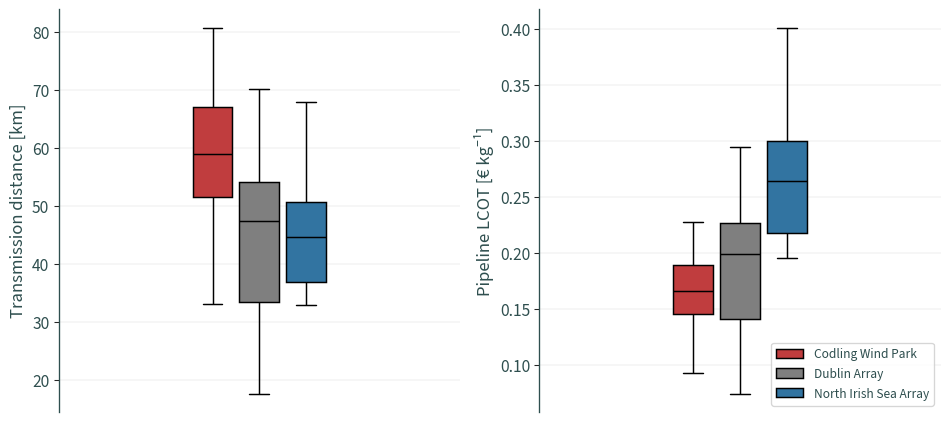

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
sns.boxplot(
    caverns.filter(like="dist_").set_axis(list(data["name"]), axis=1).melt(),
    y="value",
    hue="variable",
    palette=sns.color_palette(["tab:red", "tab:gray", "tab:blue"]),
    width=0.35,
    ax=axes[0],
    legend=False,
    linecolor="black",
    linewidth=1.1,
    gap=0.15,
)
axes[0].set_ylabel("Transmission distance [km]")
axes[0].tick_params(axis="x", bottom=False)
sns.boxplot(
    caverns.filter(like="LCOT_").set_axis(list(data["name"]), axis=1).melt(),
    y="value",
    hue="variable",
    palette=sns.color_palette(["tab:red", "tab:gray", "tab:blue"]),
    width=0.35,
    ax=axes[1],
    linecolor="black",
    linewidth=1.1,
    gap=0.15,
)
axes[1].set_ylabel("Pipeline LCOT [€ kg⁻¹]")
axes[1].legend(loc="lower right")
axes[1].tick_params(axis="x", bottom=False)
axes[1].yaxis.grid(True, linewidth=0.25)
axes[0].yaxis.grid(True, linewidth=0.25)
sns.despine(bottom=True)
plt.tight_layout()
plt.savefig(
    os.path.join("graphics", "fig_box_transmission_ntg_2gw.jpg"),
    format="jpg",
    dpi=600,
)
plt.show()

## Maps

In [43]:
shape = rd.halite_shape(dat_xr=ds).buffer(1000).buffer(-1000)

In [44]:
def plot_map_facet(
    cavern_df,
    classes,
    filename="fig_map_transmission_ntg_2gw.jpg",
    fontsize=11.5,
):
    """Helper function for plotting LCOT facet maps"""
    fig1 = plt.figure(figsize=(11, 11.75))
    xmin_, ymin_, xmax_, ymax_ = cavern_df.total_bounds
    colours = [int(n * 255 / (len(classes) - 1)) for n in range(len(classes))]
    legend_handles = []
    classes = sorted(classes)

    for n1, c in enumerate(colours):
        if n1 == 0:
            label = f"< {classes[n1]:.2f}"
        elif n1 == len(colours) - 1:
            label = f"≥ {classes[-2]:.2f}"
        else:
            label = f"{classes[n1 - 1]:.2f}–{classes[n1]:.2f}"
        legend_handles.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[c], label=label
            )
        )

    for a, wf1 in enumerate(list(wind_farms["name"])):
        ax1 = fig1.add_subplot(2, 2, a + 1, projection=ccrs.epsg(rd.CRS))
        gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
            ax=ax1,
            scheme="UserDefined",
            classification_kwds={"bins": classes},
            column=f"LCOT_{wf1.replace(' ', '_')}",
            zorder=2,
            marker=".",
            cmap="flare",
            markersize=20,
        )
        shape.plot(
            ax=ax1, color="white", alpha=0.5, edgecolor="slategrey", zorder=1
        )
        cx.add_basemap(
            ax1,
            crs=rd.CRS,
            source=cx.providers.CartoDB.VoyagerNoLabels,
            attribution=False,
        )
        ax1.gridlines(
            draw_labels={"bottom": "x"},
            color="lightslategrey",
            alpha=0.25,
            xlabel_style={"fontsize": fontsize},
            xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        )
        if not a == 1:
            ax1.gridlines(
                draw_labels={"left": "y"},
                color="lightslategrey",
                alpha=0.25,
                ylabel_style={"fontsize": fontsize, "rotation": 90},
                yformatter=LatitudeFormatter(auto_hide=False, dms=True),
            )
        if a == 2:
            ax1.add_artist(
                ScaleBar(
                    1,
                    box_alpha=0,
                    location="lower right",
                    color="darkslategrey",
                    font_properties={"size": fontsize},
                )
            )
            plt.legend(
                loc="lower right",
                bbox_to_anchor=(1, 0.075),
                handles=legend_handles,
                title="Pipeline LCOT [€ kg⁻¹]",
                fontsize=fontsize,
                title_fontsize=fontsize,
            )
        plt.xlim(xmin_ - 1000, xmax_ + 1000)
        plt.ylim(ymin_ - 1000, ymax_ + 1000)
        ax1.set_title(list(data["name"])[a])

    plt.tight_layout()
    plt.savefig(
        os.path.join("graphics", filename),
        format="jpg",
        dpi=600,
    )
    plt.show()

In [45]:
classes = mc.Quantiles(
    caverns[list(caverns.filter(like="LCOT_"))],
    k=6,
)

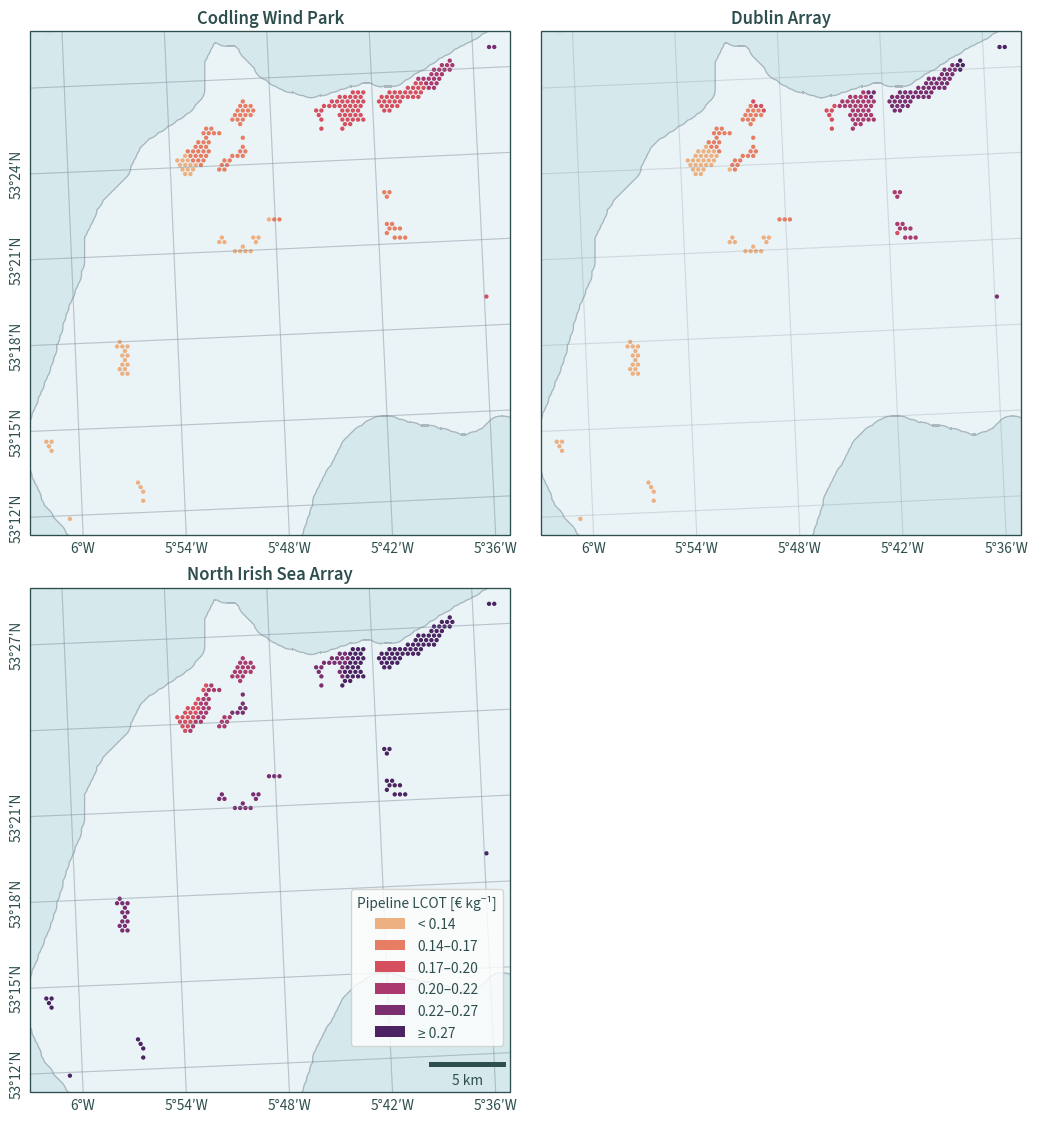

In [46]:
plot_map_facet(caverns, list(classes.bins))